# Change Point Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# use plotly to plot the data
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pyarrow.feather as feather
from scipy.signal import savgol_filter, find_peaks
from scipy.stats import ttest_ind
import pytz
import rpy2
import os
import subprocess
%load_ext rpy2.ipython

In [2]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

##### In this notebook, we will be conducting change point analysis on the steps and the environmental metrics that include CO2, noise, and VOC. We will be looking at the steps data for participants that were tagged to be in Link Lab and only participants that work in Link Lab primarily, as that means their air quality sensor is installed in their Link Lab space. 

## Steps & IEQ Data

Read steps_ll and steps_off for the different participants that work remote or in-person. In-person, we look at steps that are located in "Eschool" and for remote, we look at steps that are located "at_home."

In [3]:
# read csv
steps_ll = pd.read_csv('steps_ll.csv', parse_dates=['date','timestamp'])
# timestamp is in eastern, no need to convert
eastern = pytz.timezone('US/Eastern')
steps_ll['timestamp'] = steps_ll['timestamp'].dt.tz_localize(eastern)
# only where in_ll is true
steps_ll = steps_ll[steps_ll['in_ll'] == True]
# reset index
steps_ll = steps_ll.reset_index(drop=True)
# drop in_ll and break column
steps_ll = steps_ll.drop(columns=['group','in_ll','break'])
steps_ll.head()

,pid,day,date,timestamp,steps
0,edr,Tuesday,2022-04-26,2022-04-26 14:58:00-04:00,0.0
1,edr,Tuesday,2022-04-26,2022-04-26 14:59:00-04:00,0.0
2,edr,Tuesday,2022-04-26,2022-04-26 15:00:00-04:00,0.0
3,edr,Tuesday,2022-04-26,2022-04-26 15:01:00-04:00,0.0
4,edr,Tuesday,2022-04-26,2022-04-26 15:02:00-04:00,0.0


In [4]:
# read csv
steps_off = pd.read_csv('steps_off.csv', parse_dates=['date','timestamp'])
# timestamp is in eastern, no need to convert
steps_off['timestamp'] = steps_off['timestamp'].dt.tz_localize(eastern)
# only where in_off is true
steps_off = steps_off[steps_off['in_off'] == True]
# reset index
steps_off = steps_off.reset_index(drop=True)
steps_off = steps_off.drop(columns=['group','in_off','break'])
steps_off.head()

,pid,day,date,timestamp,steps
0,h9u,Thursday,2022-05-12,2022-05-12 17:48:00-04:00,0.0
1,h9u,Thursday,2022-05-12,2022-05-12 17:49:00-04:00,74.0
2,h9u,Thursday,2022-05-12,2022-05-12 17:50:00-04:00,74.0
3,h9u,Thursday,2022-05-12,2022-05-12 17:51:00-04:00,74.0
4,h9u,Thursday,2022-05-12,2022-05-12 17:52:00-04:00,74.0


In [5]:
# get pid, number of days
print("Participants in Link Lab")
for p in steps_ll['pid'].unique():
    print(p, len(steps_ll[steps_ll['pid'] == p]['date'].unique()))

print("Participants Off Grounds")
for p in steps_off['pid'].unique():
    print(p, len(steps_off[steps_off['pid'] == p]['date'].unique()))

Participants in Link Lab
edr 42
egl 44
mr1 28
pgm 11
ssg 25
uja 45
vxx 16
xil 38
Participants Off Grounds
h9u 28
heh 47
j02 25
lpz 10


In [6]:
ieq = pd.read_csv('ieq_iid.csv', parse_dates=['timestamp'])
# create date column
ieq['date'] = ieq['timestamp'].dt.date.astype('datetime64[ns]')
# rename ParticipantID to pid
ieq = ieq.rename(columns={'ParticipantID': 'pid'})
ieq.head()

,pid,Work,timestamp,co2ppm,noisedb,vocppb,date
0,edr,Link Lab,2022-05-13 13:58:00-04:00,776.000000,52.100000,20.333333,2022-05-13
1,edr,Link Lab,2022-05-13 13:59:00-04:00,776.166667,51.883333,20.000000,2022-05-13
2,edr,Link Lab,2022-05-13 14:00:00-04:00,777.833333,51.516667,20.166667,2022-05-13
3,edr,Link Lab,2022-05-13 14:01:00-04:00,777.166667,51.800000,20.000000,2022-05-13
4,edr,Link Lab,2022-05-13 14:02:00-04:00,776.500000,51.150000,20.000000,2022-05-13


In [7]:
ieq_ll = ieq[ieq['pid'].isin(steps_ll['pid'].unique())]
ieq_off = ieq[ieq['pid'].isin(steps_off['pid'].unique())]
# print list of participants in each group
print("Participants in Link Lab")
for p in ieq_ll['pid'].unique():
    print(p, ieq_ll[ieq_ll['pid'] == p]['timestamp'].diff().mean(), end=', ')
print("\nParticipants Off Grounds")
for p in ieq_off['pid'].unique():
    print(p, ieq_off[ieq_off['pid'] == p]['timestamp'].diff().mean(), end=', ')

Participants in Link Lab
edr 0 days 00:01:02.078890574, egl 0 days 00:01:02.078890574, mr1 0 days 00:01:02.078890574, pgm 0 days 00:01:08.082132018, ssg 0 days 00:01:02.155875245, uja 0 days 00:01:01.673832566, vxx 0 days 00:01:02.026778384, xil 0 days 00:01:02.257832678, 
Participants Off Grounds
h9u 0 days 00:05:05.092826699, heh 0 days 00:05:12.443104233, j02 0 days 00:06:06.707503828, lpz 0 days 00:05:08.123233465, 

##### Different sampling frequencies in the off ground sensors and on grounds means that steps should also be aggregated per 5 minute basis

In [8]:
# to datetime
steps_off['timestamp'] = pd.to_datetime( steps_off['timestamp'])
# set as index
steps_off.set_index('timestamp', inplace=True)
# resample the data to 5 minute intervals
steps_off = steps_off.groupby(['pid','day','date', pd.Grouper(freq='5T')])['steps'].sum().reset_index()
steps_off.head()

,pid,day,date,timestamp,steps
0,h9u,Friday,2022-06-10,2022-06-10 00:00:00-04:00,0.0
1,h9u,Friday,2022-06-10,2022-06-10 00:05:00-04:00,0.0
2,h9u,Friday,2022-06-10,2022-06-10 00:10:00-04:00,0.0
3,h9u,Friday,2022-06-10,2022-06-10 00:15:00-04:00,0.0
4,h9u,Friday,2022-06-10,2022-06-10 00:20:00-04:00,0.0


In [9]:
# merge ieq and stps on pid and date
link = pd.merge(steps_ll, ieq_ll, on=['pid', 'date', 'timestamp'])
for p in link['pid'].unique():
    print(p, len(link[link['pid'] == p]['date'].unique()))

edr 28
egl 32
mr1 22
pgm 11
ssg 21
uja 45
vxx 16
xil 30


In [10]:
off = pd.merge(steps_off, ieq_off, on=['pid', 'date', 'timestamp'])
for p in off['pid'].unique():
    print(p, len(off[off['pid'] == p]['date'].unique()))

h9u 22
heh 36
j02 20
lpz 8


In [11]:
# drop lpz and pgm
link = link[link['pid'] != 'pgm']
off = off[off['pid'] != 'lpz']

##### We split each participant into a list of dataframes where each day makes up a dataframe. We also print out the timestamp range of steps data and the number of days for each participant. The data is split by participant and further by date so that the change point analysis can be conducted on a day by day basis.

In [12]:
ll_steps = {}
for pid in link['pid'].unique():
    ll_steps[pid] = link[link['pid'] == pid]
    
    # Print pid, timestamp range, number of days
    pid_link = ll_steps[pid]
    print(pid, pid_link['timestamp'].min(), pid_link['timestamp'].max(), pid_link['date'].nunique())

    # Group by date and create a list of DataFrames
    pid_grouped = pid_link.groupby('date')
    ll_steps[pid] = [group.set_index('timestamp').sort_index() for _, group in pid_grouped]

edr 2022-05-13 14:24:00-04:00 2022-07-03 23:10:00-04:00 28


egl 2022-05-13 15:13:00-04:00 2022-07-01 23:21:00-04:00 32
mr1 2022-05-13 13:58:00-04:00 2022-07-07 17:39:00-04:00 22
ssg 2022-05-13 13:58:00-04:00 2022-07-09 20:13:00-04:00 21
uja 2022-04-26 16:26:00-04:00 2022-06-30 22:47:00-04:00 45
vxx 2022-05-06 15:04:00-04:00 2022-06-29 21:26:00-04:00 16
xil 2022-05-16 15:58:00-04:00 2022-07-12 15:21:00-04:00 30


In [13]:
off_steps = {}
for pid in off['pid'].unique():
    off_steps[pid] = off[off['pid'] == pid]
    
    # Print pid, timestamp range, number of days
    pid_off = off_steps[pid]
    print(pid, pid_off['timestamp'].min(), pid_off['timestamp'].max(), pid_off['date'].nunique())

    # Group by date and create a list of DataFrames
    pid_grouped = pid_off.groupby('date')
    off_steps[pid] = [group.set_index('timestamp').sort_index() for _, group in pid_grouped]

h9u 2022-05-31 20:00:00-04:00 2022-07-04 00:40:00-04:00 22


heh 2022-05-18 17:45:00-04:00 2022-06-23 06:00:00-04:00 36
j02 2022-05-01 01:05:00-04:00 2022-06-10 16:40:00-04:00 20


In [14]:
print("Link Lab")
# Iterate through participants and their dataframes
for pid, participant_data in ll_steps.items():
    # get the min and max count of rows for each participant
    for day_data in participant_data:
        min_count = min([len(day_data) for day_data in participant_data])
        max_count = max([len(day_data) for day_data in participant_data])
    print(pid, min_count, max_count)

# print new line then print "Off Grounds"
print("\nOff Grounds")
# Iterate through participants and their dataframes: off
for pid, participant_data in off_steps.items():
    # get the min and max count of rows for each participant
    for day_data in participant_data:
        min_count = min([len(day_data) for day_data in participant_data])
        max_count = max([len(day_data) for day_data in participant_data])
    print(pid, min_count, max_count)

Link Lab
edr 1 623
egl 91 614
mr1 163 570
ssg 11 523
uja 105 552
vxx 19 584
xil 57 602

Off Grounds
h9u 9 266
heh 1 262
j02 3 277


In [15]:
# for participant edr, how many days of data do we have?
edr = ll_steps['edr']
print('edr:', len(edr))
# what is the count of rows for each day?
for day_data in edr:
    print(len(day_data), end=',')
# print a new line
print()

# for participant ssg, how many days of data do we have?
ssg = ll_steps['ssg']
print('ssg:', len(ssg))
# what is the count of rows for each day?
for day_data in ssg:
    print(len(day_data), end=',')
    
# print a new line
print()
# same for vxx
vxx = ll_steps['vxx']
print('vxx:', len(vxx))
for day_data in vxx:
    print(len(day_data), end=',')

print()
h9u = off_steps['h9u']
print('h9u:', len(h9u))
for day_data in h9u:
    print(len(day_data), end=',')

print()
heh = off_steps['heh']
print('heh:', len(heh))
for day_data in heh:
    print(len(day_data), end=',')

print()
j02 = off_steps['j02']
print('j02:', len(j02))
for day_data in j02:
    print(len(day_data), end=',')

edr: 28
576,145,578,195,453,252,471,359,99,493,504,153,450,306,300,190,331,333,54,235,623,191,415,438,354,336,1,229,
ssg: 21
315,70,458,259,444,112,197,54,23,312,285,146,63,466,299,11,36,523,196,72,194,
vxx: 16
218,483,323,469,19,536,341,584,470,260,424,64,524,535,424,358,
h9u: 22
27,89,195,266,224,159,140,92,162,86,179,234,244,94,61,240,247,81,63,133,198,9,
heh: 36
75,117,137,76,1,104,187,111,232,133,30,248,144,144,175,228,262,151,166,142,72,83,212,111,161,197,84,2,206,174,198,231,17,54,261,73,
j02: 20
55,148,277,261,145,105,56,261,3,17,144,43,11,175,87,3,126,85,66,60,

In [16]:
# keep only frames with 60 or more rows
for pid, participant_data in ll_steps.items():
    ll_steps[pid] = [day_data for day_data in participant_data if len(day_data) >= 60]
print("Link Lab") 
# how many frames do we have for each participant?
for pid, participant_data in ll_steps.items():
    print(pid, len(participant_data))

print("\nOff Grounds")
# keep only frames with 12 or more rows (12 rows with 5 minutes each - about 60)
for pid, participant_data in off_steps.items():
    off_steps[pid] = [day_data for day_data in participant_data if len(day_data) >= 12]
# how many frames do we have for each participant?
for pid, participant_data in off_steps.items():
    print(pid, len(participant_data))

Link Lab
edr 26
egl 32
mr1 22
ssg 17
uja 45
vxx 15
xil 29

Off Grounds
h9u 21
heh 34
j02 17


In [17]:
# get edr 0 from ll_steps
ll_steps['edr'][0].head()

,pid,day,date,steps,Work,co2ppm,noisedb,vocppb
timestamp,,,,,,,,
2022-05-13 14:24:00-04:00,edr,Friday,2022-05-13,44.333333,Link Lab,754.600000,51.720000,20.800000
2022-05-13 14:25:00-04:00,edr,Friday,2022-05-13,44.333333,Link Lab,754.400000,51.760000,20.600000
2022-05-13 14:26:00-04:00,edr,Friday,2022-05-13,44.333333,Link Lab,752.500000,51.366667,20.666667
2022-05-13 14:27:00-04:00,edr,Friday,2022-05-13,0.000000,Link Lab,750.666667,51.400000,20.333333
2022-05-13 14:28:00-04:00,edr,Friday,2022-05-13,0.000000,Link Lab,749.500000,52.316667,20.500000


In [18]:
# Define the window length and polynomial order
window_length = 15  # Adjust as needed
polyorder = 2  # Adjust as needed

# Iterate through participants and their dataframes
for pid, participant_data in ll_steps.items():
    # get the min and max count of rows for each participant
    for day_data in participant_data:
        # Assuming 'co2' is the column name containing CO2 data
        day_data['co2_smoothed'] = savgol_filter(day_data['co2ppm'], window_length, polyorder)
        day_data['noise_smoothed'] = savgol_filter(day_data['noisedb'], window_length, polyorder)
        day_data['voc_smoothed'] = savgol_filter(day_data['vocppb'], window_length, polyorder)
# Now, the 'co2_smoothed' column contains the smoothed CO2 data for each day of each participant

window_length = 5
# Iterate through participants and their dataframes
for pid, participant_data in off_steps.items():
    # get the min and max count of rows for each participant
    for day_data in participant_data:
        # Assuming 'co2' is the column name containing CO2 data
        day_data['co2_smoothed'] = savgol_filter(day_data['co2ppm'], window_length, polyorder)
        day_data['noise_smoothed'] = savgol_filter(day_data['noisedb'], window_length, polyorder)
        day_data['voc_smoothed'] = savgol_filter(day_data['vocppb'], window_length, polyorder)

<AxesSubplot: xlabel='timestamp'>

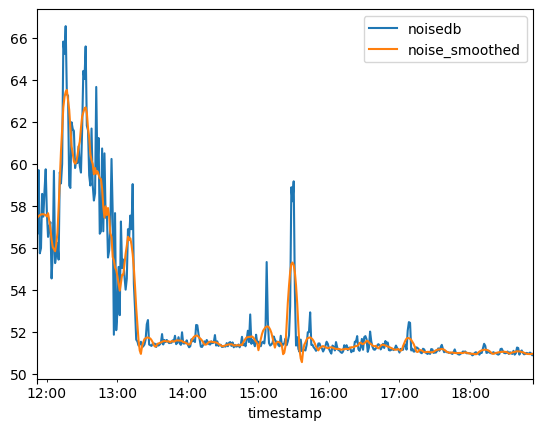

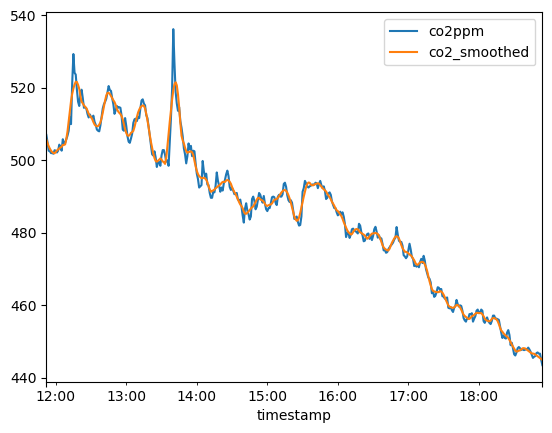

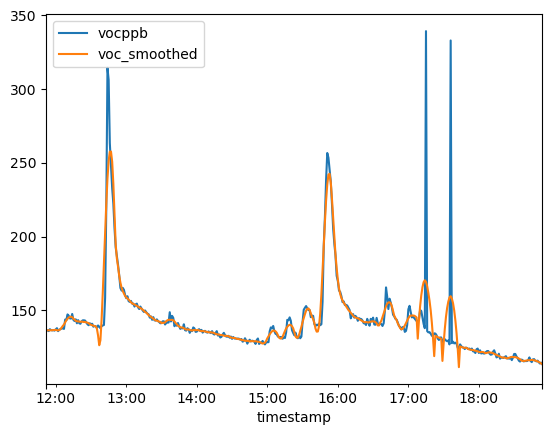

In [19]:
a = ll_steps['mr1'][7]
# plot the co2ppm and co2_smoothed columns
a[['noisedb', 'noise_smoothed']].plot()
a[['co2ppm', 'co2_smoothed']].plot()
a[['vocppb', 'voc_smoothed']].plot()

<AxesSubplot: xlabel='timestamp'>

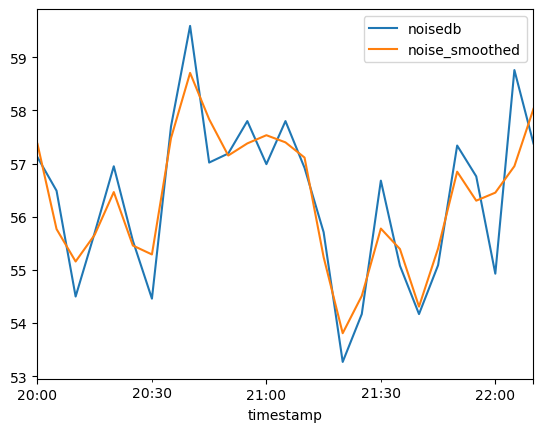

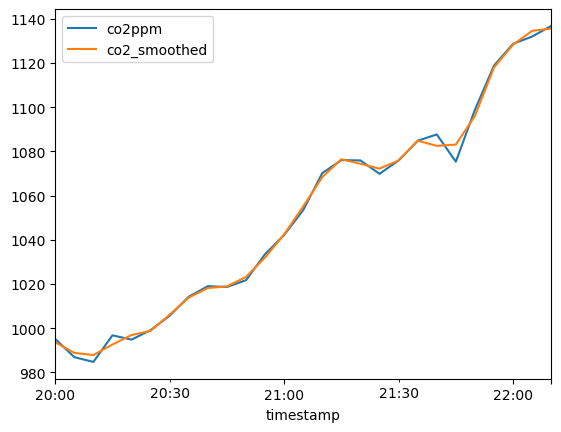

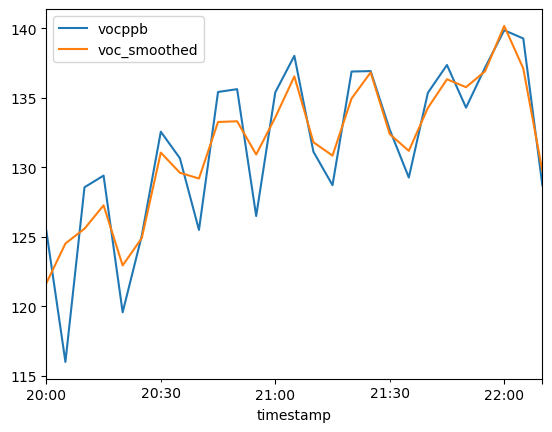

In [20]:
a = off_steps['h9u'][0]
# plot the co2ppm and co2_smoothed columns
a[['noisedb', 'noise_smoothed']].plot()
a[['co2ppm', 'co2_smoothed']].plot()
a[['vocppb', 'voc_smoothed']].plot()

In [21]:
# how many days for each participant?
for pid, participant_data in ll_steps.items():
    print(pid, len(participant_data))

# how many days for each participant?
for pid, participant_data in off_steps.items():
    print(pid, len(participant_data))

edr 26
egl 32
mr1 22
ssg 17
uja 45
vxx 15
xil 29
h9u 21
heh 34
j02 17


In [22]:
# # export to data file that will preserve the list of DataFrames
dir = "feather_exports"
output_dir = "merged_nobcp"
# folderPath = os.path.join(dir, output_dir)

# if not os.path.exists(dir):
#     os.makedirs(dir)
# if not os.path.exists(folderPath):
#     os.makedirs(folderPath)

# for pid, daily_frames in ll_steps.items():
#     for i, frame in enumerate(daily_frames):
#         feather.write_feather(frame, f"{dir}/{output_dir}/{pid}_merged_{i}.feather")

# for pid, daily_frames in off_steps.items():
#     for i, frame in enumerate(daily_frames):
#         feather.write_feather(frame, f"{dir}/{output_dir}/{pid}_merged_{i}.feather")

## Execute bcp.r script to run bayesian change points analysis

In [23]:
# # Define the relative path to your R script (assuming it's in the same directory as the Python script)
# r_script_path = 'bcp.r'

# # Define the R executable (assuming it's in your PATH)
# r_executable = 'Rscript'

# # Command to run the R script
# command = [r_executable, r_script_path]

# # Execute the R script from Python
# try:
#     subprocess.check_call(command)
#     print("R script executed successfully.")
# except subprocess.CalledProcessError:
#     print("Error: Failed to execute R script.")

#### Results for each participant will be exported to individual feather files, which should be read in.

In [24]:
# import feather files from feather_exports directory
pid_frames = {}

for file in os.listdir(dir):
    if file.endswith(".feather"):
        # pid is before the period
        pid = file.split(".")[0]
        if pid not in pid_frames:
            pid_frames[pid] = []
        pid_frames[pid].append(feather.read_feather(f"{dir}/{file}"))

# split each participant's data into separate dataframes for each day
pid_days = {}
for pid, frames in pid_frames.items():
    # drop Work column
    frames = [frame.drop(columns=['Work']) for frame in frames]
    # cast timestamp to datetime
    frames = [frame.assign(timestamp=lambda x: pd.to_datetime(x['timestamp'])) for frame in frames]
    pid_days[pid] = [group for _, group in pd.concat(frames).groupby('date')]

# how many days of data do we have for each participant?
for pid, days in pid_days.items():
    print(pid, len(days))

j02 17
ssg 17
h9u 21
edr 26
xil 29
vxx 15
mr1 22
egl 32
heh 34
uja 45


In [25]:
# are there any frames where the date does not match up to the date of the timestamp?
for pid, days in pid_days.items():
    for day in days:
        if not day['date'].equals(day['timestamp'].dt.date):
            print(pid, day['date'].equals(day['timestamp'].dt.date))

In [26]:
# create a column break to check if there is a difference of more than 1 hour between timestamps
for pid, days in pid_days.items():
    for day in days:
        day['break'] = day['timestamp'].diff() > pd.Timedelta(hours=1)

# print the participant with the list of frame indicies where break is true
for pid, days in pid_days.items():
    break_indices = [i for i, day in enumerate(days) if day['break'].any()]
    print(pid, ":", break_indices)

j02 : [1, 3, 7, 13, 15]
ssg : [0, 3, 4, 5, 7, 8, 10, 12, 13]
h9u : [2, 4, 5, 6, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]
edr : [3, 4, 5, 7, 10, 12, 13, 15, 16, 17, 18, 19, 20, 23, 25]
xil : [1, 3, 4, 5, 10, 13, 14, 19, 20, 23, 26, 28]
vxx : [0, 2, 5, 8, 9, 13, 14]
mr1 : [1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20]
egl : [0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 14, 16, 24, 31]
heh : [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 31, 32]
uja : [0, 3, 5, 7, 9, 10, 11, 12, 16, 18, 19, 22, 37, 38, 40, 41, 42]


#### In pid_days, the first level of keys are the participant ids. For each participant, the data is seperated into dataframes for each day, which can be accessed in the following way: pid_days[pid][n] where n is an integer for the different days.

### Bayesian Change Points Analysis

In [27]:
# define formmula to get indicies of peaks
def get_peaks(df, metric, bool_col):
    peaks, _ = find_peaks(df[metric], distance=25)
    df[bool_col] = False
    df.iloc[peaks, df.columns.get_loc(bool_col)] = True
    return df[bool_col]

In [28]:
link_bcp_wind = pd.DataFrame()
off_bcp_wind = pd.DataFrame()
# # find peaks in all metrics 
# threshold = 0.8
# for pid, days in pid_days.items():
#     for day in days:
#         # steps
#         day['steps_peak'] = get_peaks(day, 'stps.posterior_prob', 'steps_peak')
#         # co2
#         day['co2_peak'] = get_peaks(day, 'co2.posterior_prob', 'co2_peak')
#         # noise
#         day['noise_peak'] = get_peaks(day, 'noise.posterior_prob', 'noise_peak')
#         # voc
#         day['voc_peak'] = get_peaks(day, 'voc.posterior_prob', 'voc_peak')

#         # filter our peaks that are not above threshold
#         day['steps_peak'] = np.where(day['stps.posterior_prob'] > threshold, day['steps_peak'], False)
#         day['co2_peak'] = np.where(day['co2.posterior_prob'] > threshold, day['co2_peak'], False)
#         day['noise_peak'] = np.where(day['noise.posterior_prob'] > threshold, day['noise_peak'], False)
#         day['voc_peak'] = np.where(day['voc.posterior_prob'] > threshold, day['voc_peak'], False)


#         # steps
#         day['steps_delta'] = np.where(day['steps_peak'] == True,
#                                       (day['stps.posterior_mean'].shift(-1) - day['stps.posterior_mean'])/day['stps.posterior_mean'], 0)
#         # co2
#         day['co2_delta'] = np.where(day['co2_peak'] == True,
#                                         (day['co2.posterior_mean'].shift(-1) - day['co2.posterior_mean'])/day['co2.posterior_mean'], 0)
#         # noise
#         day['noise_delta'] = np.where(day['noise_peak'] == True,
#                                         (day['noise.posterior_mean'].shift(-1) - day['noise.posterior_mean'])/day['noise.posterior_mean'], 0)
#         # voc
#         day['voc_delta'] = np.where(day['voc_peak'] == True,
#                                         (day['voc.posterior_mean'].shift(-1) - day['voc.posterior_mean'])/day['voc.posterior_mean'], 0)
        

# # concat all the days for each participant as one dataframe
# pid_concat = pd.DataFrame()

# for pid, days in pid_days.items():
#     pid_concat = pd.concat([pid_concat, pd.concat(days)])

# # sort by pid and timestamp
# pid_concat = pid_concat.sort_values(['pid', 'timestamp'])
# # to csv
# pid_concat.to_csv('bcp_peaks.csv', index=False)


# read in csv
bcp_peaks = pd.read_csv('bcp_peaks.csv', parse_dates=['timestamp'])
# reorder columns - move timestamp column to after date
new_cols = ['pid', 'day', 'date', 'timestamp', 'steps', 'break', 'co2ppm', 'noisedb', 'vocppb', 'co2_smoothed', 'noise_smoothed', 'voc_smoothed',
       'stps.posterior_mean', 'stps.posterior_prob', 'co2.posterior_mean', 'co2.posterior_prob', 'noise.posterior_mean', 'noise.posterior_prob',
       'voc.posterior_mean', 'voc.posterior_prob', 'steps_peak', 'co2_peak', 'noise_peak', 'voc_peak', 'steps_delta', 'co2_delta', 'noise_delta','voc_delta']
# makre sure its sorted by pid and timestamp
bcp_peaks = bcp_peaks[new_cols].sort_values(['pid', 'timestamp'])
# print number of days for each participant
for pid in bcp_peaks['pid'].unique():
    print(f"{pid}: {len(bcp_peaks[bcp_peaks['pid'] == pid]['date'].unique())}")

edr: 26
egl: 32
h9u: 21
heh: 34
j02: 17
mr1: 22
ssg: 17
uja: 45
vxx: 15
xil: 29


In [29]:
# get keys from ll_steps and put it into a list
ll_pids = list(ll_steps.keys())
# get keys from off_steps and put it into a list
off_pids = list(off_steps.keys())

# split pid_concat into two dataframes
ll_concat = bcp_peaks[bcp_peaks['pid'].isin(ll_pids)]
off_concat = bcp_peaks[bcp_peaks['pid'].isin(off_pids)]

# check pids in ll_concat
for pid in ll_concat['pid'].unique():
    print(f"{pid}: {len(ll_concat[ll_concat['pid'] == pid]['date'].unique())}")

# check pids in off_concat
for pid in off_concat['pid'].unique():
    print(f"{pid}: {len(off_concat[off_concat['pid'] == pid]['date'].unique())}")

edr: 26
egl: 32
mr1: 22
ssg: 17
uja: 45
vxx: 15
xil: 29
h9u: 21
heh: 34
j02: 17


In [43]:
rolling_window = 11

# Create a copy of off_concat to store the updated data
ll_concat_updated = pd.DataFrame()
for pid in ll_concat['pid'].unique():
    # get each date
    for date in ll_concat[ll_concat['pid'] == pid]['date'].unique():
        # get the day
        day = ll_concat[(ll_concat['pid'] == pid) & (ll_concat['date'] == date)]
        
        # Apply rolling window operations
        day['steps_co2'] = np.where(day['steps_peak'] != 0,((day['co2_peak'].rolling(rolling_window, center=True).sum() != 0)), False)
        day['steps_noise'] = np.where(day['steps_peak'] != 0, ((day['noise_peak'].rolling(rolling_window, center=True).sum() != 0)), False)
        day['steps_voc'] = np.where(day['steps_peak'] != 0,((day['voc_peak'].rolling(rolling_window, center=True).sum() != 0)), False)
        
        day['co2_steps'] = np.where(day['co2_peak'] != 0,((day['steps_peak'].rolling(rolling_window, center=True).sum() != 0)), False)
        day['co2_noise'] = np.where(day['co2_peak'] != 0,((day['noise_peak'].rolling(rolling_window, center=True).sum() != 0)), False)
        day['co2_voc'] = np.where(day['co2_peak'] != 0,((day['voc_peak'].rolling(rolling_window, center=True).sum() != 0)), False)
        
        day['noise_voc'] = np.where(day['noise_peak'] != 0, ((day['voc_peak'].rolling(rolling_window, center=True).sum() != 0)), False)
        day['noise_steps'] = np.where(day['noise_peak'] != 0,((day['steps_peak'].rolling(rolling_window, center=True).sum() != 0)), False)
        day['noise_co2'] = np.where(day['noise_peak'] != 0, ((day['co2_peak'].rolling(rolling_window, center=True).sum() != 0)), False)

        day['voc_steps'] = np.where(day['voc_peak'] != 0, ((day['steps_peak'].rolling(rolling_window, center=True).sum() != 0)), False)
        day['voc_co2'] = np.where(day['voc_peak'] != 0,((day['co2_peak'].rolling(rolling_window, center=True).sum() != 0)), False)
        day['voc_noise'] = np.where(day['voc_peak'] != 0,((day['noise_peak'].rolling(rolling_window, center=True).sum() != 0)), False)
        
        # Update the original DataFrame with the updated day data
        ll_concat_updated = pd.concat([ll_concat_updated, day])

In [44]:
# get the average count of peaks in steps, co2, noise, voc, and coincidences (steps_other, co2_other, etc) for each participant
peak_comp = ll_concat_updated.groupby(['pid', 'day']).agg({
    # 'date': 'nunique', #use only if group by day
    # get average delta for each metric
    # 'steps_delta': 'mean',
    # 'co2_delta': 'mean',
    # 'noise_delta': 'mean',
    # 'voc_delta': 'mean',
    'steps_peak': 'sum',
    'co2_peak': 'sum',
    'noise_peak': 'sum',
    'voc_peak': 'sum',
    'steps_co2': 'sum',
    'steps_noise': 'sum',
    'steps_voc': 'sum',
    'co2_steps': 'sum',
    'co2_noise': 'sum',
    'co2_voc': 'sum',
    'noise_voc': 'sum',
    'noise_steps': 'sum',
    'noise_co2': 'sum',
    'voc_steps': 'sum',
    'voc_co2': 'sum',
    'voc_noise': 'sum'
})

# flatten the multiindex
peak_comp = peak_comp.reset_index()
# # calculate the porportion of peaks in steps, co2, noise, voc that are coincidences
peak_comp['steps_co2_prop'] = peak_comp['steps_co2'] / peak_comp['steps_peak']
peak_comp['steps_noise_prop'] = peak_comp['steps_noise'] / peak_comp['steps_peak']
peak_comp['steps_voc_prop'] = peak_comp['steps_voc'] / peak_comp['steps_peak']

peak_comp['co2_steps_prop'] = peak_comp['co2_steps'] / peak_comp['co2_peak']
peak_comp['co2_noise_prop'] = peak_comp['co2_noise'] / peak_comp['co2_peak']
peak_comp['co2_voc_prop'] = peak_comp['co2_voc'] / peak_comp['co2_peak']

peak_comp['noise_steps_prop'] = peak_comp['noise_steps'] / peak_comp['noise_peak']
peak_comp['noise_co2_prop'] = peak_comp['noise_co2'] / peak_comp['noise_peak']
peak_comp['noise_voc_prop'] = peak_comp['noise_voc'] / peak_comp['noise_peak']

peak_comp['voc_steps_prop'] = peak_comp['voc_steps'] / peak_comp['voc_peak']
peak_comp['voc_co2_prop'] = peak_comp['voc_co2'] / peak_comp['voc_peak']
peak_comp['voc_noise_prop'] = peak_comp['voc_noise'] / peak_comp['voc_peak']
peak_comp.head()

,pid,day,steps_peak,co2_peak,noise_peak,voc_peak,steps_co2,steps_noise,steps_voc,co2_steps,...,steps_voc_prop,co2_steps_prop,co2_noise_prop,co2_voc_prop,noise_steps_prop,noise_co2_prop,noise_voc_prop,voc_steps_prop,voc_co2_prop,voc_noise_prop
0,edr,Friday,40,7,27,10,9,12,11,2,...,0.275000,0.285714,0.571429,0.142857,0.185185,0.148148,0.037037,0.400000,0.100000,0.100000
1,edr,Monday,33,9,26,12,6,6,6,4,...,0.181818,0.444444,0.333333,0.111111,0.153846,0.115385,0.076923,0.333333,0.083333,0.166667
2,edr,Saturday,7,2,8,9,3,4,4,0,...,0.571429,0.000000,0.000000,0.000000,0.125000,0.000000,0.250000,0.111111,0.000000,0.222222
3,edr,Sunday,7,1,2,2,1,0,0,1,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,edr,Thursday,36,7,17,11,8,11,8,4,...,0.222222,0.571429,0.000000,0.428571,0.411765,0.000000,0.176471,0.363636,0.272727,0.272727


In [45]:
# average the steps_prop for each participant
pid_prop_sum = peak_comp.groupby('pid').agg({'steps_co2_prop': 'mean', 'steps_noise_prop': 'mean', 'steps_voc_prop': 'mean',
                                            'co2_steps_prop': 'mean', 'co2_noise_prop': 'mean', 'co2_voc_prop': 'mean',
                                            'noise_voc_prop': 'mean', 'noise_steps_prop': 'mean', 'noise_co2_prop': 'mean',
                                            'voc_steps_prop': 'mean', 'voc_co2_prop': 'mean', 'voc_noise_prop': 'mean'})
pid_prop_sum = pid_prop_sum.reset_index()
pid_prop_sum

,pid,steps_co2_prop,steps_noise_prop,steps_voc_prop,co2_steps_prop,co2_noise_prop,co2_voc_prop,noise_voc_prop,noise_steps_prop,noise_co2_prop,voc_steps_prop,voc_co2_prop,voc_noise_prop
0,edr,0.212485,0.252688,0.227996,0.435941,0.153061,0.204649,0.115844,0.175182,0.043362,0.255916,0.124675,0.192136
1,egl,0.171723,0.246871,0.256304,0.260668,0.195269,0.105519,0.072751,0.243122,0.078836,0.315314,0.092532,0.163961
2,mr1,0.139746,0.271214,0.171804,0.237143,0.352619,0.260238,0.135436,0.311872,0.127103,0.236368,0.117650,0.208803
3,ssg,0.282202,0.390877,0.298466,0.326667,0.166667,0.153333,0.200000,0.213095,0.050000,0.207143,0.078571,0.142857
4,uja,0.160956,0.240187,0.222402,0.199588,0.201781,0.230489,0.120122,0.183575,0.054000,0.268051,0.111550,0.200356
5,vxx,0.156049,0.230193,0.176386,0.435714,0.294286,0.378571,0.145983,0.246275,0.087222,0.244444,0.169444,0.191667
6,xil,0.210613,0.296038,0.188943,0.275794,0.278108,0.283995,0.052519,0.278799,0.073617,0.207283,0.180486,0.144091


In [122]:
# avg pid_prop_sum and append values to a dataframe indixating rolling window size
# average pid_prop_sum
temp = pid_prop_sum.mean()
# append rolling window size
temp['window'] = rolling_window * 5
# append to dataframe
off_bcp_wind = off_bcp_wind.append(temp, ignore_index=True)
off_bcp_wind

,steps_co2_prop,steps_noise_prop,steps_voc_prop,co2_steps_prop,co2_noise_prop,co2_voc_prop,noise_voc_prop,noise_steps_prop,noise_co2_prop,voc_steps_prop,voc_co2_prop,voc_noise_prop,window
0,0.034294,0.076022,0.059839,0.051053,0.108980,0.199899,0.082976,0.119903,0.113889,0.100614,0.189921,0.080665,15.0
1,0.119405,0.149861,0.124981,0.142502,0.181334,0.263206,0.158223,0.179786,0.168579,0.169030,0.238063,0.152467,25.0
2,0.174180,0.221153,0.167647,0.209887,0.266011,0.316910,0.239593,0.238011,0.205559,0.203157,0.268908,0.247461,35.0
3,0.277406,0.334872,0.273639,0.337143,0.370023,0.429283,0.335213,0.347633,0.291562,0.352131,0.373811,0.336711,55.0


In [44]:
link_bcp_wind.to_csv('bcp_summary_linklab.csv', index=False)

In [61]:
off_bcp_wind.to_csv('bcp_summary_offgrounds.csv', index=False)

### Plot Change Points

In [46]:
pid_ll_concat = pd.DataFrame()
for p in ll_concat_updated['pid'].unique():
    temp = ll_concat_updated[ll_concat_updated['pid'] == p]
    # assign same group value for same date to group column
    temp['group'] = temp['date'].factorize()[0]
    # append to dataframe
    pid_ll_concat = pid_ll_concat.append(temp)

In [48]:
pid_off_concat = pd.DataFrame()
for p in off_concat_updated['pid'].unique():
    temp = off_concat_updated[off_concat_updated['pid'] == p]
    # assign same group value for same date to group column
    temp['group'] = temp['date'].factorize()[0]
    # append to dataframe
    pid_off_concat = pid_off_concat.append(temp)

In [77]:
p = 'mr1'
d = 7

a = pid_ll_concat[(pid_ll_concat['pid'] == p) & (pid_ll_concat['group'] == d)]
# set index to timestamp
a = a.set_index('timestamp')
# get date
date = a['date'].unique()[0]

In [74]:
p = 'heh'
d = 10

a = pid_off_concat[(pid_off_concat['pid'] == p) & (pid_off_concat['group'] == d)]
# set index to timestamp
a = a.set_index('timestamp')
# get date
date = a['date'].unique()[0]

In [78]:
# Create subplots with shared x-axis
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.05)

fig.add_trace(go.Scatter(x=a.index, y=a['steps'], name='Steps', line=dict(color='#264653')), row=1, col=1)
fig.add_trace(go.Scatter(x=a.index, y=a['co2_smoothed'], name='CO2', line=dict(color='#f4a261')), row=2, col=1)
fig.add_trace(go.Scatter(x=a.index, y=a['noise_smoothed'], name='Noise', line=dict(color='#2a9d8f')), row=3, col=1)
fig.add_trace(go.Scatter(x=a.index, y=a['voc_smoothed'], name='TVOC', line=dict(color='#e76f51')), row=4, col=1)

# Add vertical dashed lines where the boolean columns are True
for i, metric in enumerate(['steps', 'co2', 'noise', 'voc']):
    bool_column = metric + '_peak'
    signal_column = metric + '_smoothed' if metric != 'steps' else 'steps'
    true_indices = a.index[a[bool_column]]
    for timestamp in true_indices:
        fig.add_shape(go.layout.Shape(
            type='line',
            x0=timestamp,
            x1=timestamp,
            y0=0,
            y1=a[signal_column].max() * 1.1,  # Adjust the y-range as needed
            # add line style dash
            line=dict(
                color='grey',
                width=1,
                dash='dash'
            ),
            xref=f'x{i + 1}',
            yref=f'y{i + 1}',
        ))

# Update subplot titles and layout
fig.update_layout(
    title=f'Metrics for {p}, Day {date}',
    xaxis_title='Timestamp',
    yaxis_title='Value',
    # increase height of subplots
    height=800,
    xaxis_title_standoff=585,
    showlegend=True,
    # set transparent background
    plot_bgcolor='white'
)


fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

# fig.update_xaxes(
#     mirror=True,
#     ticks='outside',
#     showline=True,
#     linecolor='black',
# )
fig.show()